In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from matplotlib.image import imread
import os
import datetime
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.cm as cm
import keras
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.layers import MaxPool2D,MaxPooling2D,Flatten,Dense,Conv2D,AveragePooling2D,Activation,Dropout,BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [2]:
classes = ['NORMAL', 'PNEUMONIA', 'COVID19']

class_dict={0:"NORMAL",
           1:"PNEUMONIA",
           2:"COVID19"}

change = {
'NORMAL' : '0',
'PNEUMONIA': '1',
'COVID19' : '2',
}

batch_size=32
epochs=150
image_w=224
image_h=224

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(10)


In [3]:
#/content/drive/MyDrive/Colab Notebooks/Pneumonia diagnosis system/dataset/Data/train
train_folder = '../input/chest-xray-covid19-pneumonia/Data/train'
x, y = [],[]

for category in os.listdir(train_folder):
    for file in os.listdir(os.path.join(train_folder,category)):
        x.append(os.path.join(train_folder,category,file))
        y.append(category)  

train = pd.DataFrame({
    'paths_train':x,
    'class_train':y })

train.head(10)

,paths_train,class_train
0,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
1,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
2,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
3,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
4,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
5,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
6,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
7,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
8,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
9,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA


In [4]:
train = shuffle(train, random_state=42)
train.reset_index(drop=True, inplace=True)
train.head(10)

,paths_train,class_train
0,../input/chest-xray-covid19-pneumonia/Data/tra...,COVID19
1,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
2,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
3,../input/chest-xray-covid19-pneumonia/Data/tra...,NORMAL
4,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
5,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
6,../input/chest-xray-covid19-pneumonia/Data/tra...,NORMAL
7,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
8,../input/chest-xray-covid19-pneumonia/Data/tra...,PNEUMONIA
9,../input/chest-xray-covid19-pneumonia/Data/tra...,COVID19


In [5]:
train['class_train'] = train['class_train'].map(change)
train

,paths_train,class_train
0,../input/chest-xray-covid19-pneumonia/Data/tra...,2
1,../input/chest-xray-covid19-pneumonia/Data/tra...,1
2,../input/chest-xray-covid19-pneumonia/Data/tra...,1
3,../input/chest-xray-covid19-pneumonia/Data/tra...,0
4,../input/chest-xray-covid19-pneumonia/Data/tra...,1
...,...,...
5139,../input/chest-xray-covid19-pneumonia/Data/tra...,0
5140,../input/chest-xray-covid19-pneumonia/Data/tra...,1
5141,../input/chest-xray-covid19-pneumonia/Data/tra...,1
5142,../input/chest-xray-covid19-pneumonia/Data/tra...,0


In [6]:
test_folder = '../input/chest-xray-covid19-pneumonia/Data/test'
x2, y2 = [],[]

for category in os.listdir(test_folder):
    for file in os.listdir(os.path.join(test_folder,category)):
        x2.append(os.path.join(test_folder,category,file))
        y2.append(category)  

test = pd.DataFrame({
    'paths_test':x2,
    'class_test':y2 })

test.head()

,paths_test,class_test
0,../input/chest-xray-covid19-pneumonia/Data/tes...,PNEUMONIA
1,../input/chest-xray-covid19-pneumonia/Data/tes...,PNEUMONIA
2,../input/chest-xray-covid19-pneumonia/Data/tes...,PNEUMONIA
3,../input/chest-xray-covid19-pneumonia/Data/tes...,PNEUMONIA
4,../input/chest-xray-covid19-pneumonia/Data/tes...,PNEUMONIA


In [7]:
test = shuffle(test, random_state=42)
test.reset_index(drop=True, inplace=True)
test.head()

,paths_test,class_test
0,../input/chest-xray-covid19-pneumonia/Data/tes...,NORMAL
1,../input/chest-xray-covid19-pneumonia/Data/tes...,COVID19
2,../input/chest-xray-covid19-pneumonia/Data/tes...,PNEUMONIA
3,../input/chest-xray-covid19-pneumonia/Data/tes...,PNEUMONIA
4,../input/chest-xray-covid19-pneumonia/Data/tes...,PNEUMONIA


In [8]:
test['class_test'] = test['class_test'].map(change)
test.head()

,paths_test,class_test
0,../input/chest-xray-covid19-pneumonia/Data/tes...,0
1,../input/chest-xray-covid19-pneumonia/Data/tes...,2
2,../input/chest-xray-covid19-pneumonia/Data/tes...,1
3,../input/chest-xray-covid19-pneumonia/Data/tes...,1
4,../input/chest-xray-covid19-pneumonia/Data/tes...,1


In [9]:
train, val = train_test_split(train, test_size=0.1, random_state=0, stratify=train['class_train'])
print(train['class_train'].value_counts(dropna=False))
print(val['class_train'].value_counts(dropna=False))

1    3076
0    1139
2     414
Name: class_train, dtype: int64
1    342
0    127
2     46
Name: class_train, dtype: int64


In [10]:
val.head()

,paths_train,class_train
3050,../input/chest-xray-covid19-pneumonia/Data/tra...,0
2183,../input/chest-xray-covid19-pneumonia/Data/tra...,0
341,../input/chest-xray-covid19-pneumonia/Data/tra...,0
1995,../input/chest-xray-covid19-pneumonia/Data/tra...,0
836,../input/chest-xray-covid19-pneumonia/Data/tra...,0


In [11]:
datagen = ImageDataGenerator(
                                rescale = 1./255,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                zoom_range=0.2,
                                fill_mode='nearest',
                                horizontal_flip=True,
                                vertical_flip=False, 
                            )


test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
train_data = datagen.flow_from_dataframe(train,
                                        x_col="paths_train",
                                        y_col="class_train",
                                        target_size=(image_w,image_h),
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=True,
                                        num_parallel_calls=AUTOTUNE)


val_data = test_datagen.flow_from_dataframe(val,
                                        x_col="paths_train",
                                        y_col="class_train",
                                        target_size=(image_w,image_h),
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)


test_data = test_datagen.flow_from_dataframe(test,
                                        x_col="paths_test",
                                        y_col="class_test",
                                        target_size=(image_w,image_h),
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

Found 4629 validated image filenames belonging to 3 classes.
Found 515 validated image filenames belonging to 3 classes.
Found 1288 validated image filenames belonging to 3 classes.


In [13]:
from tensorflow.keras.applications import VGG19
pretrained_vgg =VGG19(input_shape=(image_w, image_h, 3), weights='imagenet', include_top=False)
pretrained_vgg.trainable=False
for layer in pretrained_vgg.layers[-6:]:
    layer.trainable = True

x = pretrained_vgg.output
x = AveragePooling2D(name="averagepooling2d")(x)
x = Flatten(name="flatten")(x)
x = Dense(512, activation="relu", name="dense_0")(x)
x = Dropout(0.15, name="dropout_0")(x)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="output")(x)

model = Model(inputs=pretrained_vgg.input, outputs=model_out)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()

2023-02-05 10:02:51.191529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 10:02:51.192455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 10:02:51.201970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 10:02:51.202777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 10:02:51.203520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

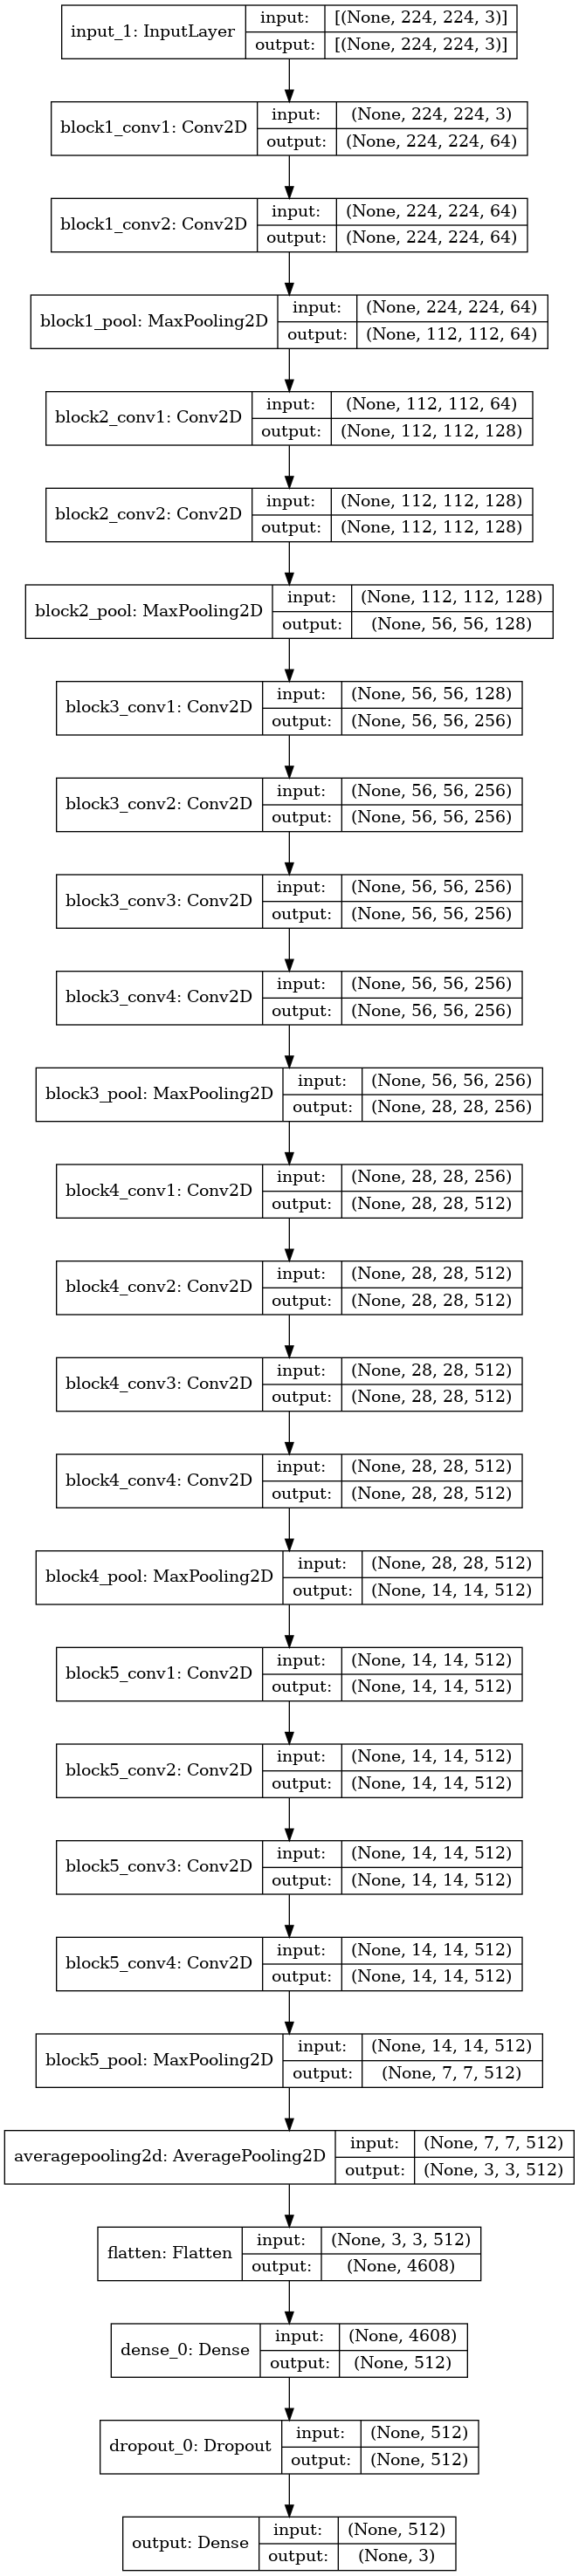

In [15]:
keras.utils.plot_model(model,show_shapes=True)

In [16]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")

checkpoint = ModelCheckpoint("loss-{val_loss:.4f}.h5", monitor="val_loss", verbose=1, 
                             save_best_only=True, save_weights_only=True, mode="min")

learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1, mode="min")

In [17]:
train_steps = train_data.samples // batch_size
valid_steps = val_data.samples // batch_size
print(train_steps)
print(valid_steps)

144
16


In [18]:
init_time = datetime.datetime.now()

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[
                checkpoint, 
                early_stopping, 
                learning_rate_reduction],
    verbose=1,
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

2023-02-05 10:02:55.174631: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2023-02-05 10:02:58.132288: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


144/144 [==============================] - 234s 2s/step - loss: 0.8929 - accuracy: 0.6633 - val_loss: 0.5384 - val_accuracy: 0.7988

Epoch 00001: val_loss improved from inf to 0.53839, saving model to loss-0.5384.h5
Epoch 2/150
144/144 [==============================] - 181s 1s/step - loss: 0.4880 - accuracy: 0.8144 - val_loss: 0.3338 - val_accuracy: 0.8809

Epoch 00002: val_loss improved from 0.53839 to 0.33383, saving model to loss-0.3338.h5
Epoch 3/150
144/144 [==============================] - 181s 1s/step - loss: 0.3276 - accuracy: 0.8764 - val_loss: 0.2725 - val_accuracy: 0.9258

Epoch 00003: val_loss improved from 0.33383 to 0.27253, saving model to loss-0.2725.h5
Epoch 4/150
144/144 [==============================] - 179s 1s/step - loss: 0.2558 - accuracy: 0.9023 - val_loss: 0.2987 - val_accuracy: 0.8848

Epoch 00004: val_loss did not improve from 0.27253
Epoch 5/150
144/144 [==============================] - 178s 1s/step - loss: 0.2226 - accuracy: 0.9199 - val_loss: 0.2795 - v

In [19]:
history_df = pd.DataFrame(history.history)
min_loss=history_df['val_loss'].min()
print("Minimum Validation Loss: {:0.4f}".format(min_loss));

Minimum Validation Loss: 0.1346


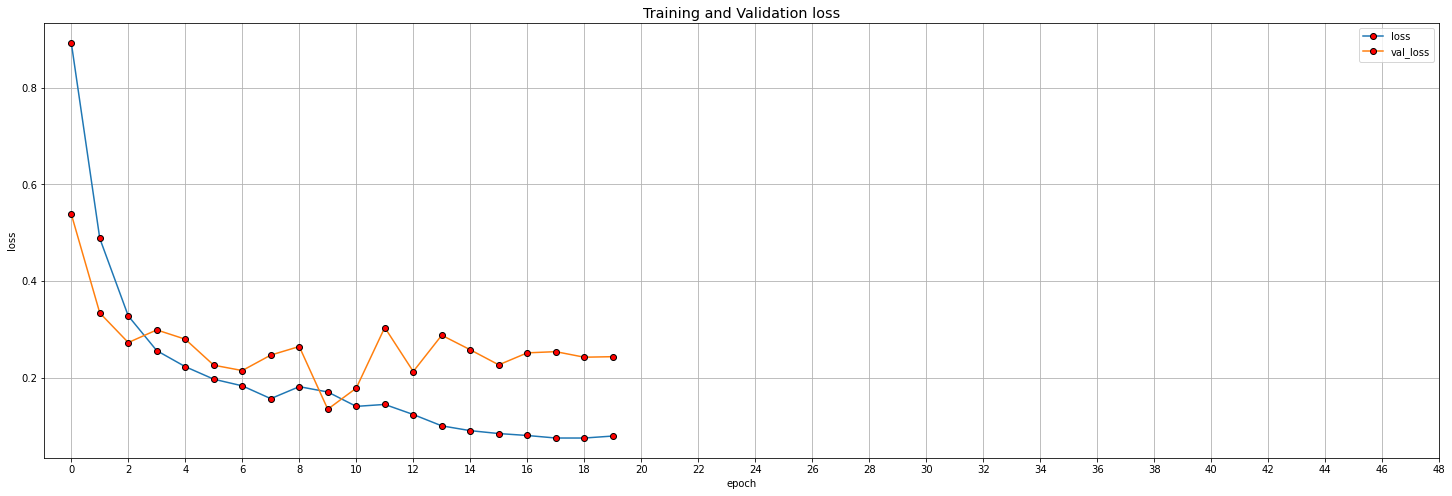

In [20]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(figsize =(25,8), marker = "o", mfc = "r")
plt.style.use('classic')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.grid(axis='both')
plt.xticks(np.arange(0, 50, 2))
plt.show()

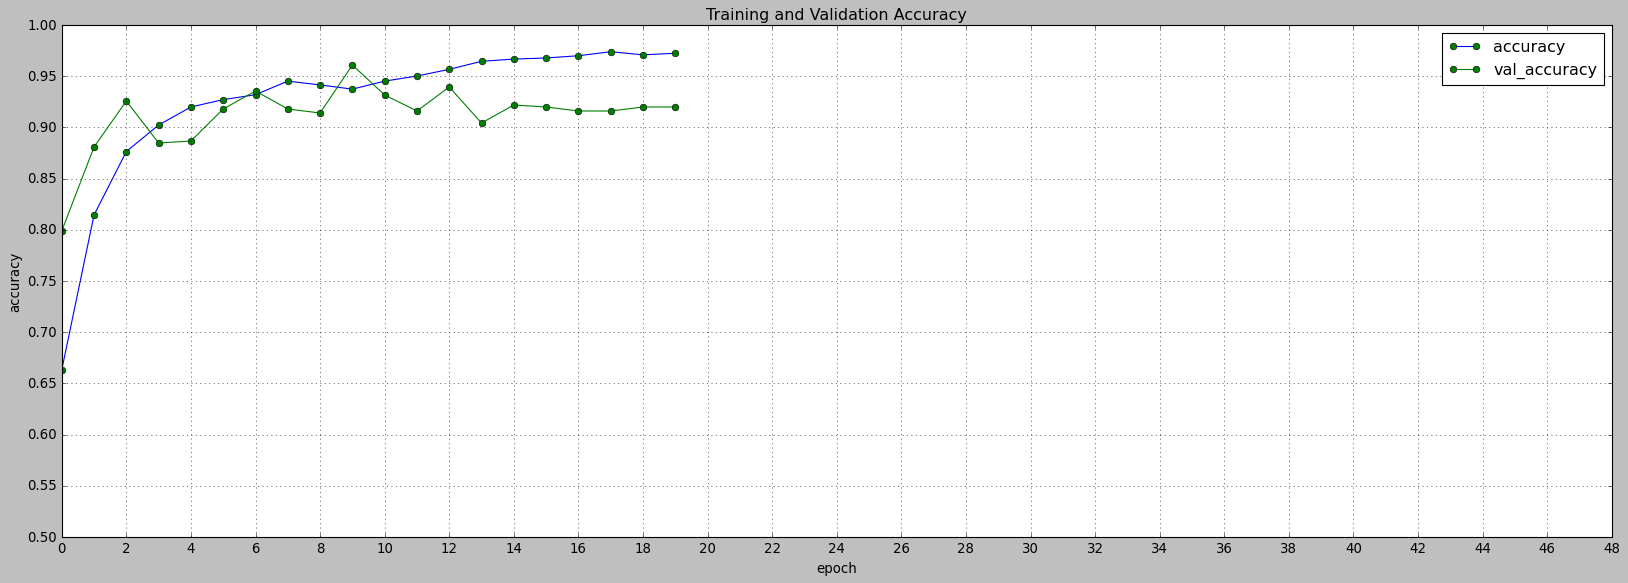

In [21]:
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot(figsize =(25,8), marker = "o", mfc = "g")

plt.style.use('classic')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(axis='both')
plt.xticks(np.arange(0, 50, 2))
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.show()

In [22]:
model.load_weights('loss-{:0.4f}.h5'.format(min_loss))

test_steps = test_data.samples // batch_size

test_loss, test_acc = model.evaluate(test_data,steps=test_steps)

print('\naccuracy: {}%'.format(round(test_acc*100,2)), '\nloss: {:0.4f}'.format(test_loss))


40/40 [==============================] - 43s 1s/step - loss: 0.1347 - accuracy: 0.9492

accuracy: 94.92% 
loss: 0.1347


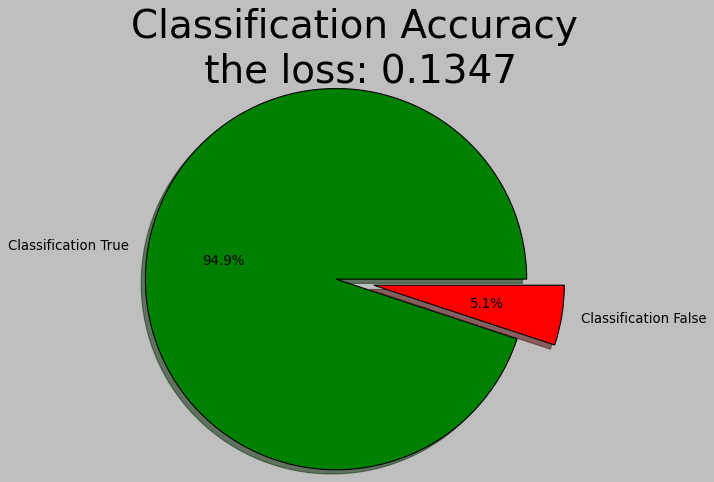

In [23]:
plt.style.use('classic')
plt.pie([test_acc,1-test_acc],labels=('Classification True','Classification False')
        ,explode=[0.1,0.1],autopct="%1.1f%%",shadow=True,colors=['green','red'])
plt.axis('equal')
plt.title('Classification Accuracy\n the loss: {:0.4f}'.format(test_loss),fontsize=35)
plt.show()

In [24]:
model.save('vgg19.h5')

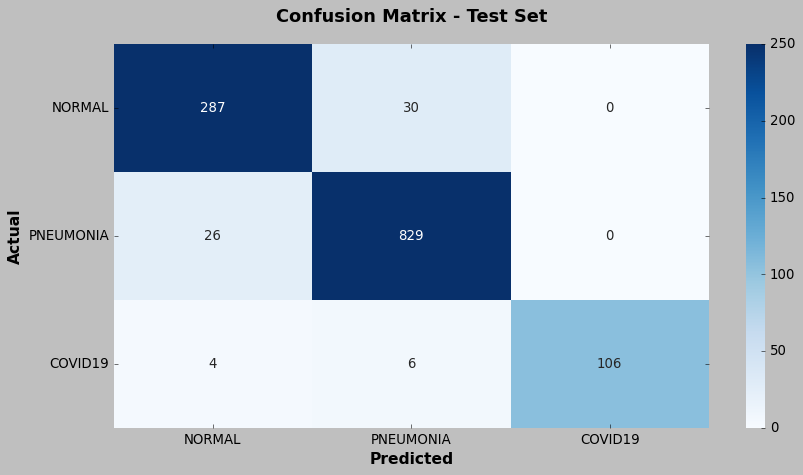

In [25]:
y_pred=model.predict(test_data)
predictions=np.array(list(map(lambda x:np.argmax(x),y_pred)))
y_true=test_data.classes
CMatrix=pd.DataFrame(confusion_matrix(y_true,predictions),columns=classes,index=classes)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [26]:
def find_true_class(file_path):
    true_class = None
    if 'COVID19' in file_path:
        true_class = 'COVID19'
    elif 'PNEUMONIA' in file_path:
        true_class = 'PNEUMONIA'
    elif 'NORMAL' in file_path:
        true_class = 'NORMAL'
    return true_class


# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()



# https://keras.io/examples/vision/grad_cam/
def superimposed_img(img, heatmap,pred_class,pred_prob_final):

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM

    plt.matshow(superimposed_img)

    plt.xticks([])
    plt.yticks([])

    plt.title('Predict: '+str(pred_class)+'\n Confidence: '+str(pred_prob_final)+"%",fontsize=25, weight='bold');

    plt.show()


# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
last_conv_layer_name = "block5_conv4"
classifier_layer_names = [
    "block5_conv4",
    'block5_pool',
    "averagepooling2d",
    "flatten",
    "dense_0",
    "dropout_0",
    "output",
]

In [29]:
def img_rgb(img_test_path):

    test_image=cv2.imread(img_test_path,cv2.IMREAD_COLOR)
    test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
    test_image=cv2.resize(test_image,(224,224))
    
    return test_image 


def imshow(img_test_path):
    
    img_test_list=list(img_test_path.split('/'))
    test_image=img_rgb(img_test_path)
    plt.xticks([])
    plt.yticks([])
    plt.title('the Actual Class: :{}'.format(img_test_list[-2]),fontsize=25)
    plt.imshow(test_image)
    plt.show()
    

    
def show_visual_img(img_test_path):
    
    test_image=img_rgb(img_test_path)
    
    test_image=np.expand_dims(test_image,axis=0)
    
    img=img_rgb(img_test_path)
    
    img=np.expand_dims(img,axis=0)

    img=img/255.0
    
    score = model.predict(img)


    pred_class_num=np.argmax(score)
#     print(pred_class_num)
    pred_class=class_dict[pred_class_num]
#     print(pred_class)

    pred_prob=np.max(score) * 100
#     print(pred_prob)
    pred_prob_final=round(pred_prob,2)

    heatmap, top_index = make_gradcam_heatmap(test_image, 
                                              model, 
                                              last_conv_layer_name, 
                                              classifier_layer_names)

    superimposed_img(test_image[0], heatmap,pred_class,pred_prob_final)

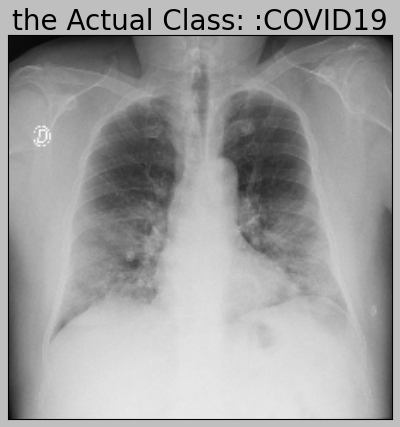

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


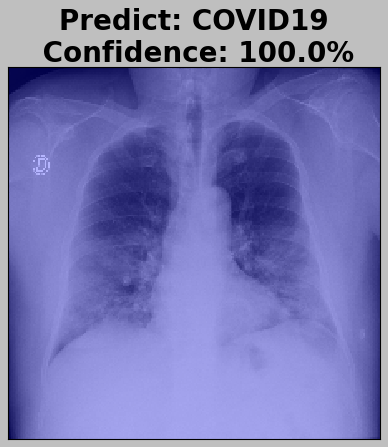

In [30]:
img_test_path='/kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19/COVID19(480).jpg'
imshow(img_test_path)
show_visual_img(img_test_path)

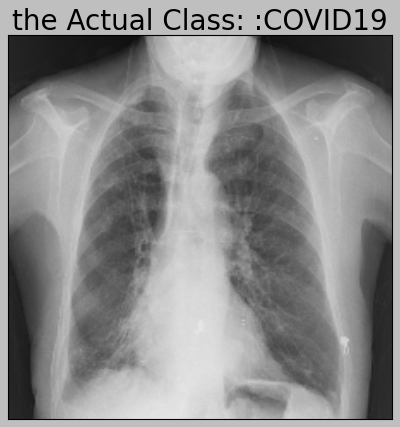

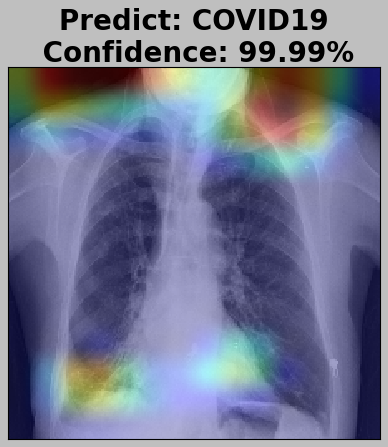

In [31]:
img_test_path='/kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19/COVID19(490).jpg'
imshow(img_test_path)
show_visual_img(img_test_path)